# 模态I CHAMBER=4 conv2d 虚拟量测 conv2d [ok]

In [91]:
# 导入包
# This makes it so that matplotlib graphics will show up within the Jupyter Notebook.
%matplotlib inline

# Standard library import

# Data Analysis Tools
import pandas as pd
import numpy as np

# Visualization Tools
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning Tools
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# File Loading Tools 
import os

import pickle

In [2]:
import utils.functions_plot as PL

## 导入模态I腔室4的训练数据和测试数据，reshape X用于conv2d

In [3]:
X_train = np.load("./data phm 2016/X_train_r_modeI_chamber4_mm.npy")
y_train = np.load("./data phm 2016/y_train_modeI_chamber4_mm.npy")
X_test = np.load("./data phm 2016/X_test_r_modeI_chamber4_mm.npy")
y_test = np.load("./data phm 2016/y_test_modeI_chamber4_mm.npy")
print('X_train shape: ', X_train.shape)
print('y_train shape: ', y_train.shape)
print('X_test shape: ', X_test.shape)
print('y_test shape: ', y_test.shape)

X_train shape:  (798, 263, 19)
y_train shape:  (798, 1)
X_test shape:  (165, 263, 19)
y_test shape:  (165, 1)


In [4]:
# 基本参数
wafer_number, max_batch_length, variable_number = X_train.shape
wafer_number_test = X_test.shape[0]
print('训练集晶圆个数：', wafer_number)
print('最长时间序列长度：', max_batch_length)
print('字段个数：', variable_number)
print('训练集晶圆个数：', wafer_number_test)

训练集晶圆个数： 798
最长时间序列长度： 263
字段个数： 19
训练集晶圆个数： 165


In [5]:
# reshape X for conv2d
X_train_r = X_train.reshape((wafer_number, max_batch_length, variable_number, 1))
X_test_r = X_test.reshape((wafer_number_test, max_batch_length, variable_number, 1))
print('X_train_r shape: ', X_train_r.shape)
print('X_test_r shape: ', X_test_r.shape)

X_train_r shape:  (798, 263, 19, 1)
X_test_r shape:  (165, 263, 19, 1)


## y归一化(当网络优化器没有使用reduce_lr机制的时候将y归一化，预测结果再映射回原值可以加快学习速度)

In [6]:
# from sklearn.preprocessing import StandardScaler
# ss = StandardScaler()
# y_train_ss = ss.fit_transform(y_train)

## conv2d

In [20]:
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Flatten, Conv2D, Dropout, MaxPool2D
from tensorflow.keras.optimizers import SGD, Adam, Adagrad
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping

In [13]:
# 构建网络
# 文兰硕士论文
# activation=relu filters=[16,32,64,16] pool_size=[2,2,2,2] kernel_size=[2,2,2,2] Hidden_unit=[64,16,1]
# adam-400 early_stopping, reduce_lr
# Tensorflow 2.0
model = Sequential()

model.add(Conv2D(filters=16, kernel_size=[2, 2], padding='same', input_shape=(max_batch_length, variable_number, 1), name='conv2d1'))
model.add(Activation('relu' , name='active1'))
model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='same', name='pool1'))

model.add(Conv2D(filters=32, kernel_size=[2, 2], padding='same', name='conv2d2'))
model.add(Activation('relu', name='active2'))
model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='same', name='pool2'))

model.add(Conv2D(filters=64, kernel_size=[2, 2], padding='same', name='conv2d3'))
model.add(Activation('relu', name='active3'))
model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='same', name='pool3'))

model.add(Conv2D(filters=16, kernel_size=[2, 2], padding='same', name='conv2d4'))
model.add(Activation('relu', name='active4'))
model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='same', name='pool4'))

model.add(Flatten(name='flatten'))
model.add(Dense(64, name='dense1'))
model.add(Activation('relu', name='active_dense1'))

model.add(Dense(16, name='dense2'))
model.add(Activation('relu', name='active_dense2'))

model.add(Dense(1, name='dense3'))
model.add(Activation('linear', name='active_dense3'))

print(model.summary())

# Define Optimizer and setup Parameter
# adagrad = Adagrad(learning_rate=0.1)
# # y归一化
# model.compile(optimizer='adagrad', loss='mean_squared_error', metrics=['mse'])

# y未归一化
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])


# Run/Fireup network
nb_epoch = 1000
batch_size = 399

# EarlyStop=EarlyStopping(monitor='mse', patience=2,verbose=1, mode='min')
Reduce=ReduceLROnPlateau(monitor='mse',
                         factor=0.5,
                         patience=10,
                         verbose=1,
                         mode='min',
                         min_delta=0.0001,
                         cooldown=0,
                         min_lr=1e-10)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d1 (Conv2D)            (None, 263, 19, 16)       80        
                                                                 
 active1 (Activation)        (None, 263, 19, 16)       0         
                                                                 
 pool1 (MaxPooling2D)        (None, 132, 10, 16)       0         
                                                                 
 conv2d2 (Conv2D)            (None, 132, 10, 32)       2080      
                                                                 
 active2 (Activation)        (None, 132, 10, 32)       0         
                                                                 
 pool2 (MaxPooling2D)        (None, 66, 5, 32)         0         
                                                                 
 conv2d3 (Conv2D)            (None, 66, 5, 64)        

In [14]:
# train set
# # y归一化
# model.fit(x=X_train_r, y=y_train_ss, epochs=nb_epoch, batch_size=batch_size) #, callbacks=[Reduce])

# y未归一化
history_model_conv2d = model.fit(x=X_train_r, y=y_train, epochs=nb_epoch, batch_size=batch_size, callbacks=[Reduce])

Epoch 1/1000
2/2 [==============================] - 1s 422ms/step - loss: 5376.3945 - mse: 5376.3945 - lr: 0.0010
Epoch 2/1000
2/2 [==============================] - 1s 403ms/step - loss: 5354.2007 - mse: 5354.2007 - lr: 0.0010
Epoch 3/1000
2/2 [==============================] - 1s 406ms/step - loss: 5318.3384 - mse: 5318.3384 - lr: 0.0010
Epoch 4/1000
2/2 [==============================] - 1s 400ms/step - loss: 5259.0225 - mse: 5259.0225 - lr: 0.0010
Epoch 5/1000
2/2 [==============================] - 1s 407ms/step - loss: 5162.7344 - mse: 5162.7344 - lr: 0.0010
Epoch 6/1000
2/2 [==============================] - 1s 413ms/step - loss: 5020.7305 - mse: 5020.7305 - lr: 0.0010
Epoch 7/1000
2/2 [==============================] - 1s 398ms/step - loss: 4813.5459 - mse: 4813.5459 - lr: 0.0010
Epoch 8/1000
2/2 [==============================] - 1s 412ms/step - loss: 4514.1187 - mse: 4514.1187 - lr: 0.0010
Epoch 9/1000
2/2 [==============================] - 1s 444ms/step - loss: 4083.7744 - ms

2/2 [==============================] - 1s 392ms/step - loss: 58.8312 - mse: 58.8312 - lr: 0.0010
Epoch 75/1000
2/2 [==============================] - 1s 401ms/step - loss: 58.6100 - mse: 58.6100 - lr: 0.0010
Epoch 76/1000
2/2 [==============================] - 1s 402ms/step - loss: 58.4219 - mse: 58.4219 - lr: 0.0010
Epoch 77/1000
2/2 [==============================] - 1s 408ms/step - loss: 58.2293 - mse: 58.2293 - lr: 0.0010
Epoch 78/1000
2/2 [==============================] - 1s 399ms/step - loss: 58.0229 - mse: 58.0229 - lr: 0.0010
Epoch 79/1000
2/2 [==============================] - 1s 415ms/step - loss: 57.8077 - mse: 57.8077 - lr: 0.0010
Epoch 80/1000
2/2 [==============================] - 1s 402ms/step - loss: 57.5725 - mse: 57.5725 - lr: 0.0010
Epoch 81/1000
2/2 [==============================] - 1s 411ms/step - loss: 57.3171 - mse: 57.3171 - lr: 0.0010
Epoch 82/1000
2/2 [==============================] - 1s 389ms/step - loss: 57.0619 - mse: 57.0619 - lr: 0.0010
Epoch 83/1000
2

2/2 [==============================] - 1s 416ms/step - loss: 41.1349 - mse: 41.1349 - lr: 0.0010
Epoch 148/1000
2/2 [==============================] - 1s 389ms/step - loss: 41.1135 - mse: 41.1135 - lr: 0.0010
Epoch 149/1000
2/2 [==============================] - 1s 413ms/step - loss: 40.9489 - mse: 40.9489 - lr: 0.0010
Epoch 150/1000
2/2 [==============================] - 1s 391ms/step - loss: 40.6302 - mse: 40.6302 - lr: 0.0010
Epoch 151/1000
2/2 [==============================] - 1s 393ms/step - loss: 40.6174 - mse: 40.6174 - lr: 0.0010
Epoch 152/1000
2/2 [==============================] - 1s 393ms/step - loss: 40.4498 - mse: 40.4498 - lr: 0.0010
Epoch 153/1000
2/2 [==============================] - 1s 408ms/step - loss: 40.3331 - mse: 40.3331 - lr: 0.0010
Epoch 154/1000
2/2 [==============================] - 1s 409ms/step - loss: 40.2077 - mse: 40.2077 - lr: 0.0010
Epoch 155/1000
2/2 [==============================] - 1s 390ms/step - loss: 40.1071 - mse: 40.1071 - lr: 0.0010
Epoch 1

2/2 [==============================] - 1s 418ms/step - loss: 32.4001 - mse: 32.4001 - lr: 0.0010
Epoch 221/1000
2/2 [==============================] - 1s 406ms/step - loss: 32.3308 - mse: 32.3308 - lr: 0.0010
Epoch 222/1000
2/2 [==============================] - 1s 407ms/step - loss: 32.3463 - mse: 32.3463 - lr: 0.0010
Epoch 223/1000
2/2 [==============================] - 1s 421ms/step - loss: 32.0039 - mse: 32.0039 - lr: 0.0010
Epoch 224/1000
2/2 [==============================] - 1s 402ms/step - loss: 31.9678 - mse: 31.9678 - lr: 0.0010
Epoch 225/1000
2/2 [==============================] - 1s 422ms/step - loss: 31.7586 - mse: 31.7586 - lr: 0.0010
Epoch 226/1000
2/2 [==============================] - 1s 424ms/step - loss: 31.9729 - mse: 31.9729 - lr: 0.0010
Epoch 227/1000
2/2 [==============================] - 1s 408ms/step - loss: 31.4640 - mse: 31.4640 - lr: 0.0010
Epoch 228/1000
2/2 [==============================] - 1s 420ms/step - loss: 31.6576 - mse: 31.6576 - lr: 0.0010
Epoch 2

2/2 [==============================] - 1s 425ms/step - loss: 25.7722 - mse: 25.7722 - lr: 0.0010
Epoch 294/1000
2/2 [==============================] - 1s 409ms/step - loss: 25.7009 - mse: 25.7009 - lr: 0.0010
Epoch 295/1000
2/2 [==============================] - 1s 432ms/step - loss: 25.6727 - mse: 25.6727 - lr: 0.0010
Epoch 296/1000
2/2 [==============================] - 1s 403ms/step - loss: 25.5112 - mse: 25.5112 - lr: 0.0010
Epoch 297/1000
2/2 [==============================] - 1s 417ms/step - loss: 25.5090 - mse: 25.5090 - lr: 0.0010
Epoch 298/1000
2/2 [==============================] - 1s 425ms/step - loss: 25.3923 - mse: 25.3923 - lr: 0.0010
Epoch 299/1000
2/2 [==============================] - 1s 396ms/step - loss: 25.1832 - mse: 25.1832 - lr: 0.0010
Epoch 300/1000
2/2 [==============================] - 1s 409ms/step - loss: 25.3070 - mse: 25.3070 - lr: 0.0010
Epoch 301/1000
2/2 [==============================] - 1s 414ms/step - loss: 25.1281 - mse: 25.1281 - lr: 0.0010
Epoch 3

2/2 [==============================] - 1s 418ms/step - loss: 22.4095 - mse: 22.4095 - lr: 0.0010
Epoch 367/1000
2/2 [==============================] - 1s 413ms/step - loss: 22.4176 - mse: 22.4176 - lr: 0.0010
Epoch 368/1000
2/2 [==============================] - 1s 461ms/step - loss: 22.2096 - mse: 22.2096 - lr: 0.0010
Epoch 369/1000
2/2 [==============================] - 1s 446ms/step - loss: 22.1602 - mse: 22.1602 - lr: 0.0010
Epoch 370/1000
2/2 [==============================] - 1s 402ms/step - loss: 22.0587 - mse: 22.0587 - lr: 0.0010
Epoch 371/1000
2/2 [==============================] - 1s 434ms/step - loss: 21.8561 - mse: 21.8561 - lr: 0.0010
Epoch 372/1000
2/2 [==============================] - 1s 439ms/step - loss: 22.0424 - mse: 22.0424 - lr: 0.0010
Epoch 373/1000
2/2 [==============================] - 1s 435ms/step - loss: 21.8731 - mse: 21.8731 - lr: 0.0010
Epoch 374/1000
2/2 [==============================] - 1s 422ms/step - loss: 21.8259 - mse: 21.8259 - lr: 0.0010
Epoch 3

2/2 [==============================] - 1s 420ms/step - loss: 20.9193 - mse: 20.9193 - lr: 0.0010
Epoch 440/1000
2/2 [==============================] - 1s 435ms/step - loss: 20.4671 - mse: 20.4671 - lr: 0.0010
Epoch 441/1000
2/2 [==============================] - 1s 423ms/step - loss: 20.4553 - mse: 20.4553 - lr: 0.0010
Epoch 442/1000
2/2 [==============================] - 1s 432ms/step - loss: 20.6015 - mse: 20.6015 - lr: 0.0010
Epoch 443/1000
2/2 [==============================] - 1s 428ms/step - loss: 20.5161 - mse: 20.5161 - lr: 0.0010
Epoch 444/1000
2/2 [==============================] - 1s 405ms/step - loss: 20.4081 - mse: 20.4081 - lr: 0.0010
Epoch 445/1000
2/2 [==============================] - 1s 422ms/step - loss: 20.5131 - mse: 20.5131 - lr: 0.0010
Epoch 446/1000
2/2 [==============================] - 1s 418ms/step - loss: 20.4083 - mse: 20.4083 - lr: 0.0010
Epoch 447/1000
2/2 [==============================] - 1s 422ms/step - loss: 20.3963 - mse: 20.3963 - lr: 0.0010
Epoch 4

2/2 [==============================] - 1s 419ms/step - loss: 19.7831 - mse: 19.7831 - lr: 0.0010
Epoch 513/1000
2/2 [==============================] - 1s 420ms/step - loss: 19.7882 - mse: 19.7882 - lr: 0.0010
Epoch 514/1000
2/2 [==============================] - 1s 418ms/step - loss: 19.8471 - mse: 19.8471 - lr: 0.0010
Epoch 515/1000
2/2 [==============================] - 1s 419ms/step - loss: 19.7907 - mse: 19.7907 - lr: 0.0010
Epoch 516/1000
2/2 [==============================] - 1s 419ms/step - loss: 19.7445 - mse: 19.7445 - lr: 0.0010
Epoch 517/1000
2/2 [==============================] - 1s 433ms/step - loss: 19.8749 - mse: 19.8749 - lr: 0.0010
Epoch 518/1000
2/2 [==============================] - 1s 432ms/step - loss: 19.8350 - mse: 19.8350 - lr: 0.0010
Epoch 519/1000
2/2 [==============================] - 1s 425ms/step - loss: 19.7882 - mse: 19.7882 - lr: 0.0010
Epoch 520/1000
2/2 [==============================] - 1s 415ms/step - loss: 19.8474 - mse: 19.8474 - lr: 0.0010
Epoch 5

2/2 [==============================] - 1s 431ms/step - loss: 19.3811 - mse: 19.3811 - lr: 5.0000e-04
Epoch 583/1000
2/2 [==============================] - 1s 438ms/step - loss: 19.4752 - mse: 19.4752 - lr: 5.0000e-04
Epoch 584/1000
2/2 [==============================] - 1s 416ms/step - loss: 19.3972 - mse: 19.3972 - lr: 5.0000e-04
Epoch 585/1000
2/2 [==============================] - 1s 419ms/step - loss: 19.3708 - mse: 19.3708 - lr: 5.0000e-04
Epoch 586/1000
2/2 [==============================] - 1s 439ms/step - loss: 19.3576 - mse: 19.3576 - lr: 5.0000e-04
Epoch 587/1000
2/2 [==============================] - 1s 428ms/step - loss: 19.3540 - mse: 19.3540 - lr: 5.0000e-04
Epoch 588/1000
2/2 [==============================] - 1s 444ms/step - loss: 19.3541 - mse: 19.3541 - lr: 5.0000e-04
Epoch 589/1000
2/2 [==============================] - 1s 431ms/step - loss: 19.3939 - mse: 19.3939 - lr: 5.0000e-04
Epoch 590/1000
2/2 [==============================] - 1s 426ms/step - loss: 19.3227 - m

2/2 [==============================] - 1s 404ms/step - loss: 19.0983 - mse: 19.0983 - lr: 2.5000e-04
Epoch 652/1000
2/2 [==============================] - 1s 409ms/step - loss: 19.1042 - mse: 19.1042 - lr: 2.5000e-04
Epoch 653/1000
2/2 [==============================] - 1s 418ms/step - loss: 19.0972 - mse: 19.0972 - lr: 2.5000e-04
Epoch 654/1000
2/2 [==============================] - 1s 401ms/step - loss: 19.0842 - mse: 19.0842 - lr: 2.5000e-04
Epoch 655/1000
2/2 [==============================] - 1s 419ms/step - loss: 19.0892 - mse: 19.0892 - lr: 2.5000e-04
Epoch 656/1000
2/2 [==============================] - 1s 406ms/step - loss: 19.1019 - mse: 19.1019 - lr: 2.5000e-04
Epoch 657/1000
2/2 [==============================] - 1s 410ms/step - loss: 19.0764 - mse: 19.0764 - lr: 2.5000e-04
Epoch 658/1000
2/2 [==============================] - 1s 398ms/step - loss: 19.0694 - mse: 19.0694 - lr: 2.5000e-04
Epoch 659/1000
2/2 [==============================] - 1s 403ms/step - loss: 19.0757 - m

2/2 [==============================] - 1s 436ms/step - loss: 18.9067 - mse: 18.9067 - lr: 2.5000e-04
Epoch 722/1000
2/2 [==============================] - 1s 410ms/step - loss: 18.9004 - mse: 18.9004 - lr: 2.5000e-04
Epoch 723/1000
2/2 [==============================] - 1s 419ms/step - loss: 18.8960 - mse: 18.8960 - lr: 2.5000e-04
Epoch 724/1000
2/2 [==============================] - 1s 438ms/step - loss: 18.8908 - mse: 18.8908 - lr: 2.5000e-04
Epoch 725/1000
2/2 [==============================] - 1s 429ms/step - loss: 18.8952 - mse: 18.8952 - lr: 2.5000e-04
Epoch 726/1000
2/2 [==============================] - 1s 464ms/step - loss: 18.8958 - mse: 18.8958 - lr: 2.5000e-04
Epoch 727/1000
2/2 [==============================] - 1s 427ms/step - loss: 18.9169 - mse: 18.9169 - lr: 2.5000e-04
Epoch 728/1000
2/2 [==============================] - 1s 485ms/step - loss: 18.8932 - mse: 18.8932 - lr: 2.5000e-04
Epoch 729/1000
2/2 [==============================] - 1s 439ms/step - loss: 18.8861 - m

2/2 [==============================] - 1s 426ms/step - loss: 18.6818 - mse: 18.6818 - lr: 2.5000e-04
Epoch 792/1000
2/2 [==============================] - 1s 414ms/step - loss: 18.7021 - mse: 18.7021 - lr: 2.5000e-04
Epoch 793/1000
2/2 [==============================] - 1s 395ms/step - loss: 18.6740 - mse: 18.6740 - lr: 2.5000e-04
Epoch 794/1000
2/2 [==============================] - 1s 425ms/step - loss: 18.6804 - mse: 18.6804 - lr: 2.5000e-04
Epoch 795/1000
2/2 [==============================] - 1s 433ms/step - loss: 18.6773 - mse: 18.6773 - lr: 2.5000e-04
Epoch 796/1000
2/2 [==============================] - 1s 426ms/step - loss: 18.6703 - mse: 18.6703 - lr: 2.5000e-04
Epoch 797/1000
2/2 [==============================] - 1s 410ms/step - loss: 18.6673 - mse: 18.6673 - lr: 2.5000e-04
Epoch 798/1000
2/2 [==============================] - 1s 426ms/step - loss: 18.6646 - mse: 18.6646 - lr: 2.5000e-04
Epoch 799/1000
2/2 [==============================] - 1s 410ms/step - loss: 18.6682 - m

2/2 [==============================] - 1s 393ms/step - loss: 18.5201 - mse: 18.5201 - lr: 2.5000e-04
Epoch 862/1000
2/2 [==============================] - 1s 414ms/step - loss: 18.5359 - mse: 18.5359 - lr: 2.5000e-04
Epoch 863/1000
2/2 [==============================] - 1s 402ms/step - loss: 18.5793 - mse: 18.5793 - lr: 2.5000e-04
Epoch 864/1000
2/2 [==============================] - 1s 422ms/step - loss: 18.4596 - mse: 18.4596 - lr: 2.5000e-04
Epoch 865/1000
2/2 [==============================] - 1s 435ms/step - loss: 18.5080 - mse: 18.5080 - lr: 2.5000e-04
Epoch 866/1000
2/2 [==============================] - 1s 437ms/step - loss: 18.5215 - mse: 18.5215 - lr: 2.5000e-04
Epoch 867/1000
2/2 [==============================] - 1s 431ms/step - loss: 18.4624 - mse: 18.4624 - lr: 2.5000e-04
Epoch 868/1000
2/2 [==============================] - 1s 440ms/step - loss: 18.4497 - mse: 18.4497 - lr: 2.5000e-04
Epoch 869/1000
2/2 [==============================] - 1s 418ms/step - loss: 18.4607 - m

2/2 [==============================] - 1s 408ms/step - loss: 18.2681 - mse: 18.2681 - lr: 2.5000e-04
Epoch 932/1000
2/2 [==============================] - 1s 426ms/step - loss: 18.2733 - mse: 18.2733 - lr: 2.5000e-04
Epoch 933/1000
2/2 [==============================] - 1s 420ms/step - loss: 18.2581 - mse: 18.2581 - lr: 2.5000e-04
Epoch 934/1000
2/2 [==============================] - 1s 414ms/step - loss: 18.2618 - mse: 18.2618 - lr: 2.5000e-04
Epoch 935/1000
2/2 [==============================] - 1s 430ms/step - loss: 18.2594 - mse: 18.2594 - lr: 2.5000e-04
Epoch 936/1000
2/2 [==============================] - 1s 430ms/step - loss: 18.3060 - mse: 18.3060 - lr: 2.5000e-04
Epoch 937/1000
2/2 [==============================] - 1s 420ms/step - loss: 18.2686 - mse: 18.2686 - lr: 2.5000e-04
Epoch 938/1000
2/2 [==============================] - 1s 436ms/step - loss: 18.2684 - mse: 18.2684 - lr: 2.5000e-04
Epoch 939/1000
2/2 [==============================] - 1s 442ms/step - loss: 18.2870 - m

In [16]:
y_train_pre = model.predict(X_train_r)

# # y归一化
# y_train_pre = ss.inverse_transform(y_train_pre)

y_train_pre

array([[73.338165],
       [73.678734],
       [72.99879 ],
       [74.50637 ],
       [70.27192 ],
       [65.13602 ],
       [67.56439 ],
       [67.62392 ],
       [65.229706],
       [75.00069 ],
       [69.82502 ],
       [71.9492  ],
       [73.67918 ],
       [61.798954],
       [70.35121 ],
       [64.18745 ],
       [61.353382],
       [69.58277 ],
       [66.496284],
       [66.55228 ],
       [64.63743 ],
       [61.350605],
       [72.68573 ],
       [69.87707 ],
       [67.9771  ],
       [59.418827],
       [70.44923 ],
       [61.401295],
       [60.478962],
       [62.596535],
       [61.3127  ],
       [70.94575 ],
       [77.06901 ],
       [61.255   ],
       [66.93124 ],
       [74.64541 ],
       [61.788162],
       [59.847248],
       [58.817196],
       [64.90552 ],
       [70.474205],
       [63.440342],
       [61.41782 ],
       [62.96413 ],
       [57.833553],
       [75.37657 ],
       [62.382793],
       [74.09248 ],
       [72.50224 ],
       [73.48535 ],


MSE:  18.07721120877272
RMSE:  4.251730378184007
MAE:  3.283905942445531
R^2:  0.5911993133647039
max absolute error:  22.331655139160155
min absolute error:  0.0011324218749990678
mean absolute error:  3.283905942445531
std absolute error:  2.7005875231037506




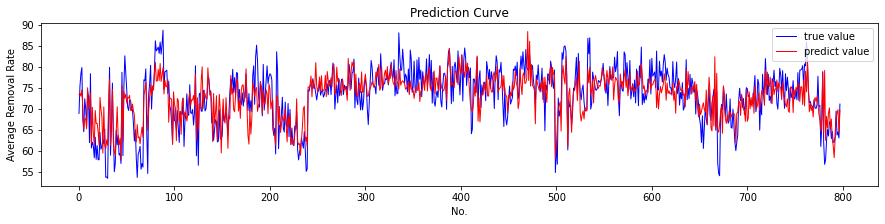

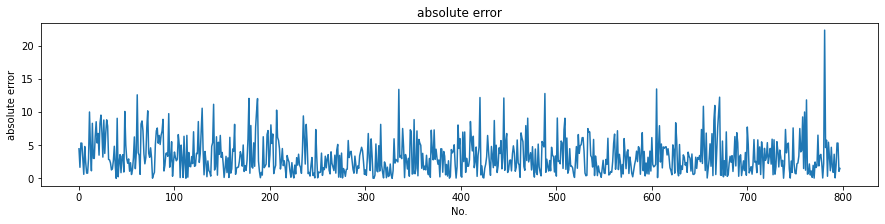

In [17]:
PL.plot_predict_curve(y_train, y_train_pre)

MSE:  21.91114930019322
RMSE:  4.680934660961763
MAE:  3.548066937033914
R^2:  0.468481305811403
max absolute error:  15.06037552490234
min absolute error:  0.06807618408203098
mean absolute error:  3.548066937033914
std absolute error:  3.053255690327948




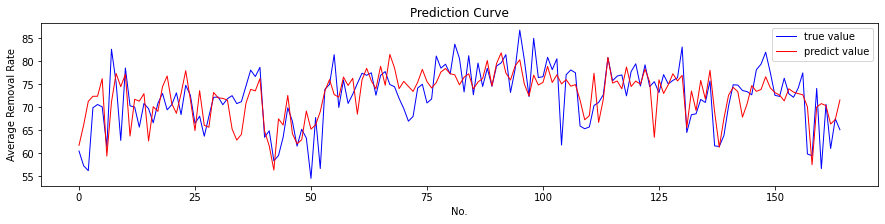

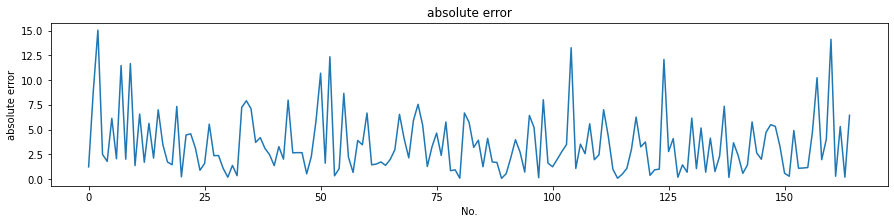

In [18]:
y_test_pre = model.predict(X_test_r)
# # y归一化
# y_test_pre = ss.inverse_transform(y_test_pre)
PL.plot_predict_curve(y_test, y_test_pre)

In [15]:
# # save results
# pickle.dump(y_test_pre, open('./results_save/predictions_conv2d.pkl', 'wb'))

In [8]:
# # save model
# model.save('./save_model/modeI_conv2d.h5')

In [56]:
# 画中间的输出
def explain_intermediate(layer_name, shape):
    layer = model.get_layer(layer_name).output
    intermediate_layer_model = Model(inputs=model.input, outputs=layer)
    # pre train and test for conv1d layer
    output_train = intermediate_layer_model.predict(X_train)
    output_test = intermediate_layer_model.predict(X_test)
    print(output_train.shape)
    print(output_test.shape)
    
    plt.figure(figsize=(12, output_train.shape[3]))
    for i in range(0, output_train.shape[3]):
        plt.subplot(int(output_train.shape[3]/4), 4, i+1)
        plt.imshow(output_train[4,:,:,i].reshape(shape))
        plt.title(f'Channel-{i}')
    plt.colorbar()
    plt.show()

(798, 263, 19, 16)
(165, 263, 19, 16)


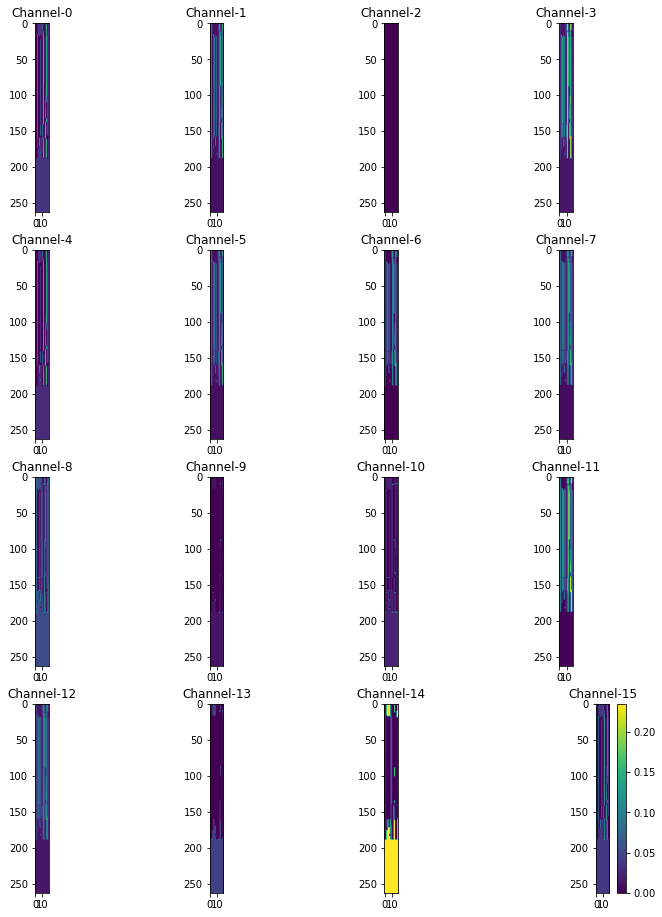

In [63]:
explain_intermediate(layer_name='active1', shape=(263,19))

(798, 132, 10, 32)
(165, 132, 10, 32)


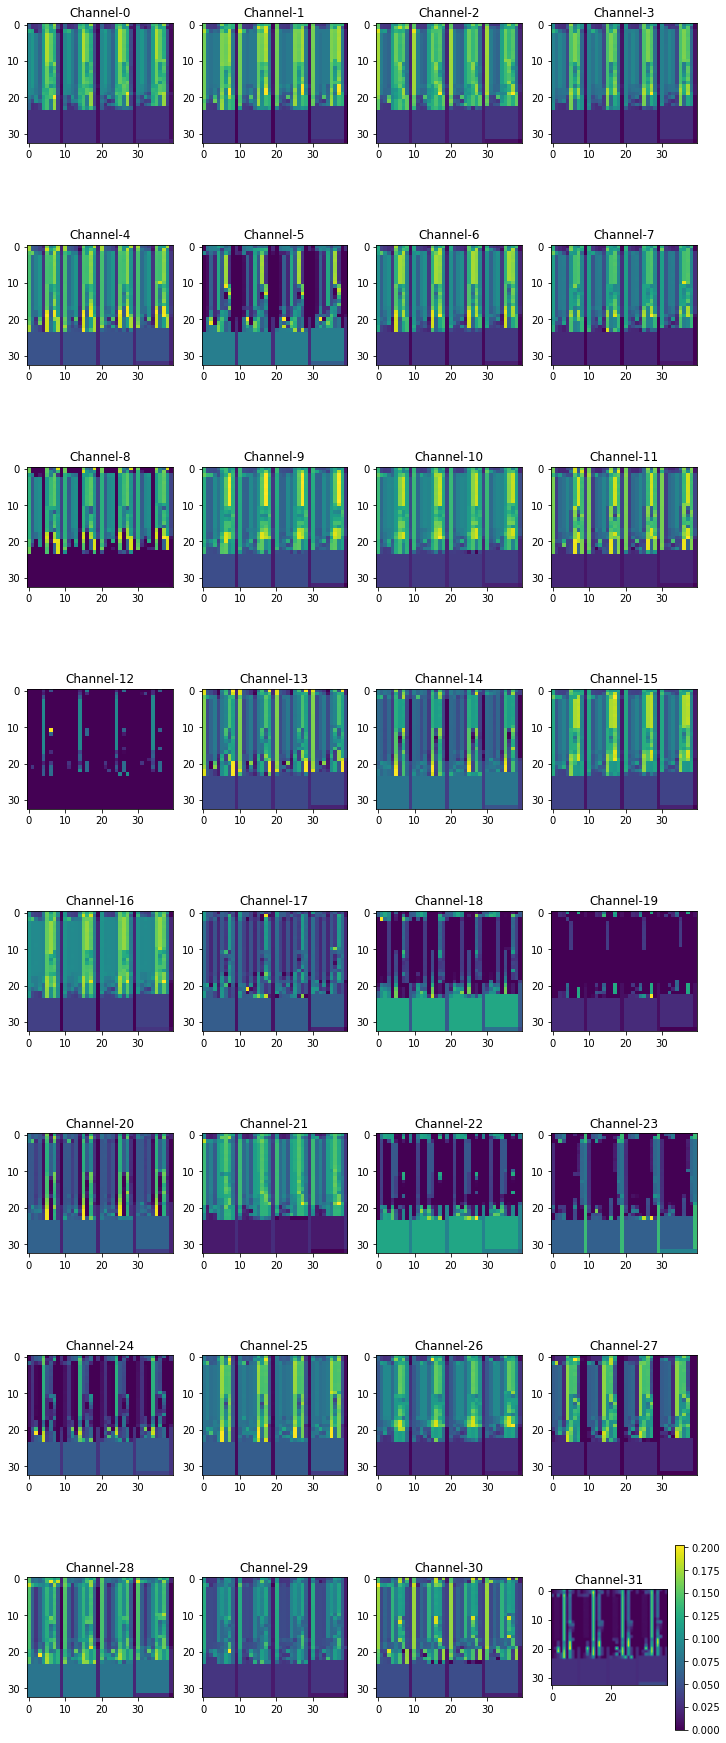

In [62]:
explain_intermediate(layer_name='active2', shape=(33,40))

(798, 66, 5, 64)
(165, 66, 5, 64)


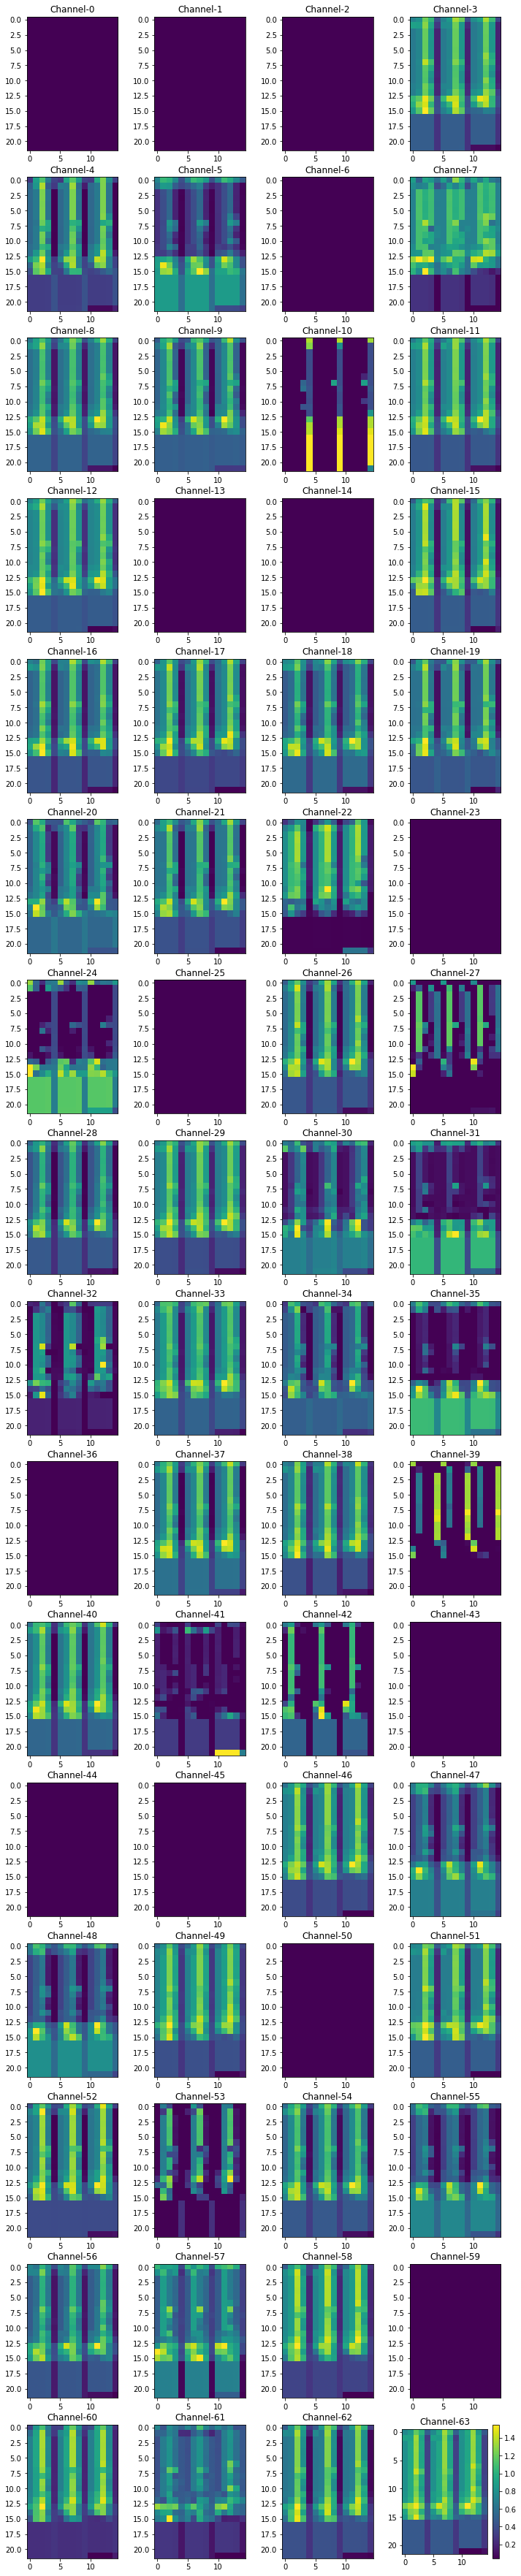

In [61]:
explain_intermediate(layer_name='active3', shape=(22,15))

(798, 33, 3, 16)
(165, 33, 3, 16)


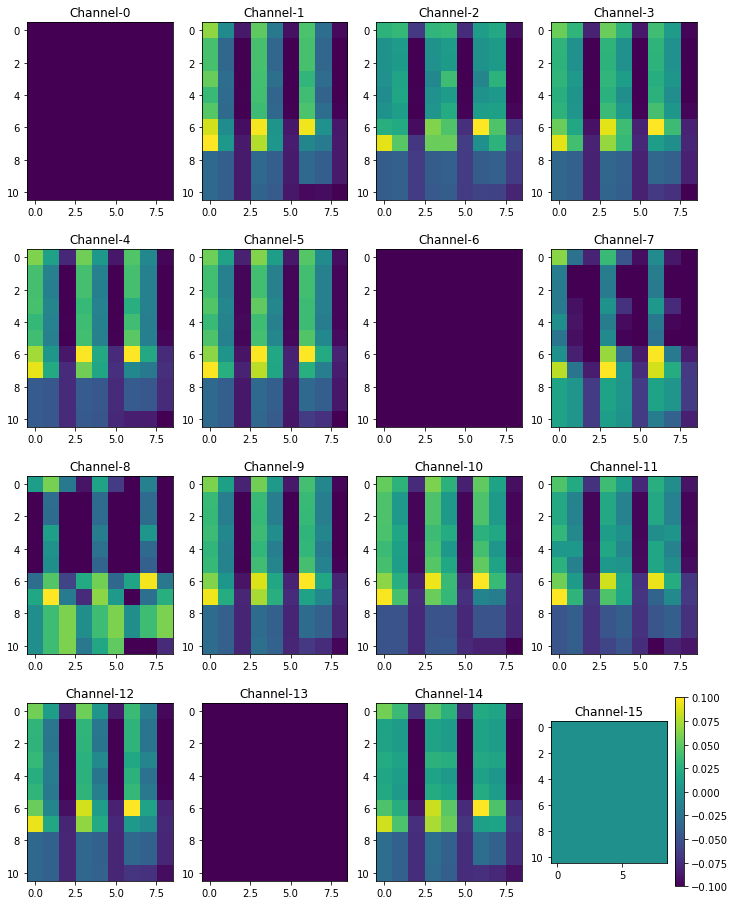

In [60]:
explain_intermediate(layer_name='active4', shape=(11,9))

(165, 33, 3, 16)


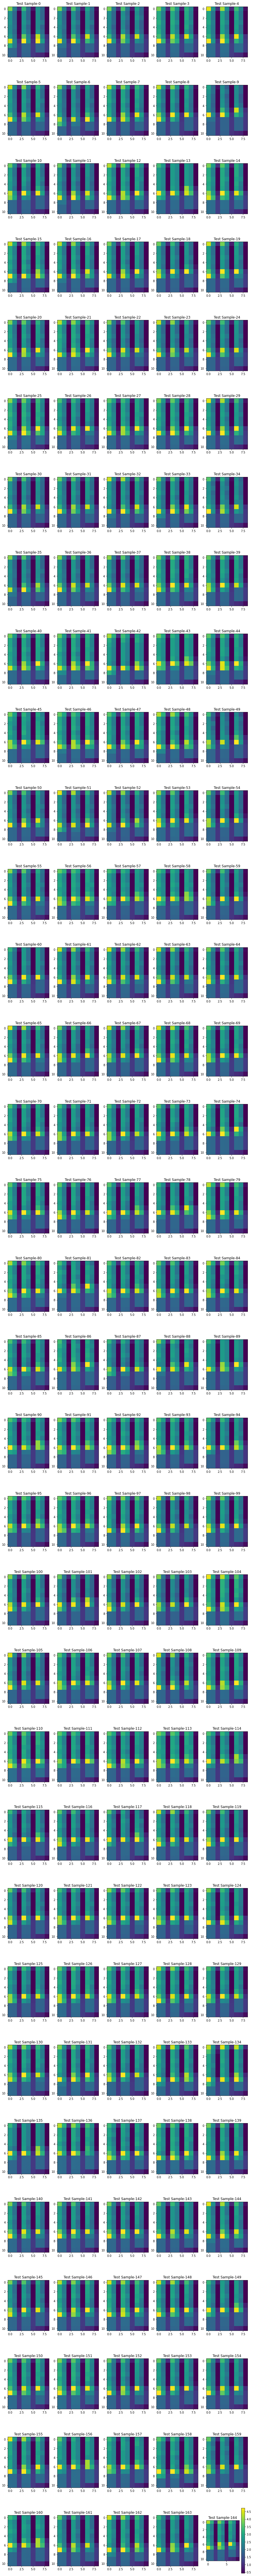

In [100]:
# 画中间的输出特征，取出来平均值
def extract_intermediate_by_sample(layer_name, shape):
layer_name = 'active4'
shape = (11,9)

layer = model.get_layer(layer_name).output
intermediate_layer_model = Model(inputs=model.input, outputs=layer)
output_test = intermediate_layer_model.predict(X_test)
print(output_test.shape)

images = output_test.mean(axis=3)
plt.figure(figsize=(15, 165))
for i in range(0,165):
    plt.subplot(33,5, i+1)
    plt.imshow(images[i].reshape(shape))
    plt.title(f'Test Sample-{i}')
plt.colorbar()
plt.show()

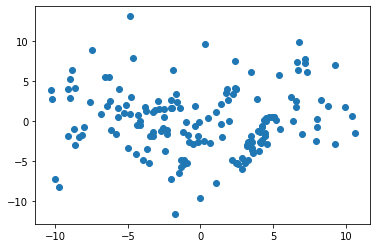

In [96]:
# 降维到PCA之后效果还不错
data = images.reshape((165,99))
ss = StandardScaler()
pca = PCA(n_components=2)
data_reduced = pca.fit_transform(ss.fit_transform(data))

plt.figure()
plt.scatter(data_reduced[:,0], data_reduced[:,1])
plt.show()

/Users/lihan/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/lihan/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


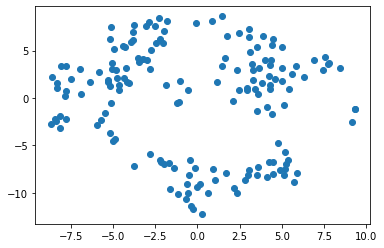

In [98]:
ss = StandardScaler()
tsne = TSNE(n_components=2)
data_reduced = tsne.fit_transform(ss.fit_transform(data))

plt.figure()
plt.scatter(data_reduced[:,0], data_reduced[:,1])
plt.show()